## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Загружаем данные

In [2]:
df=pd.read_csv('/datasets/taxi.csv')

In [3]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [6]:
df = df.set_index('datetime')

In [7]:
df = df.resample('1H').sum()

In [8]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Данные загружены и изучены.
Произведено ресеплирование по одному часу.

# 2. Анализ

Постром график со скользящими стандартным отклонением и средним

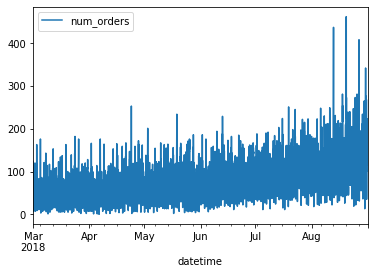

In [9]:
df.plot()


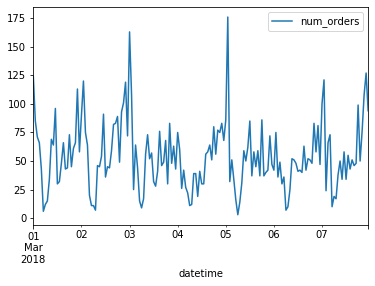

In [10]:
df.head(24*7).plot()

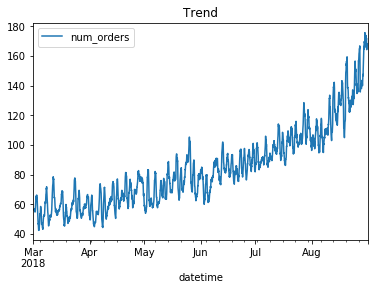

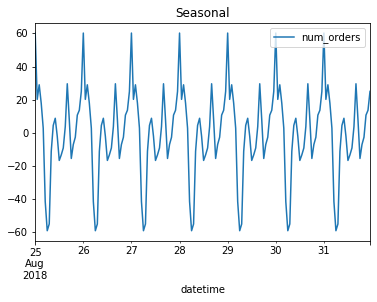

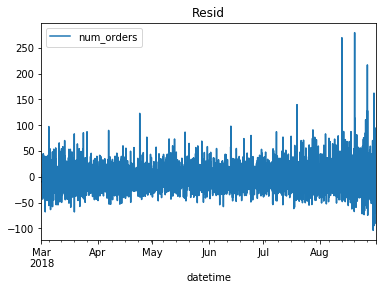

In [11]:
decomposed_data = seasonal_decompose(df)
decomposed_data.trend.plot(title='Trend')
decomposed_data.seasonal.tail(24*7).plot(title='Seasonal')
decomposed_data.resid.plot(title='Resid')

In [12]:
data = df
data['rolling_mean'] = data['num_orders'].shift().rolling(12).mean()
data['std'] = data['num_orders'].rolling(12).std()

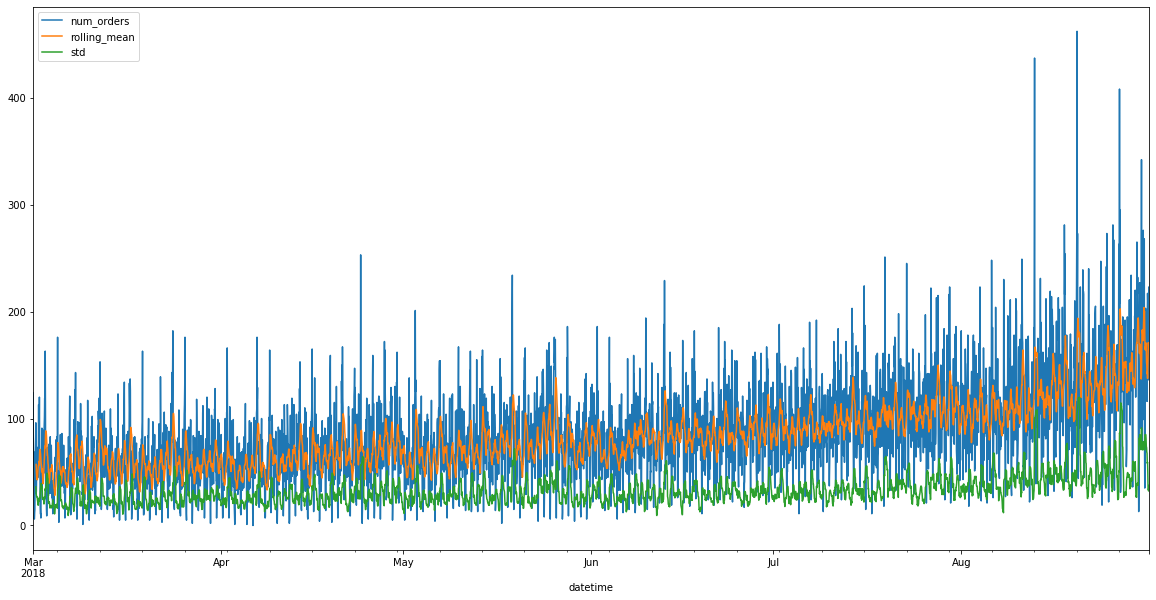

In [13]:
data.plot(figsize=([20,10]))

**Вывод:**

Судя по графику можно сделать вывод, что среднее значение и стандартное отклонение со временем увеличиваются, значит временной ряд нестационарный.

# 3. Обучение и тестирование

In [14]:
def make_features(data, max_lag, size_1):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    #косинусно-синусное преобразование времени для отображения циклического характера часов
    data['s_hour'] = np.sin(2*np.pi*data['hour']/24)
    data['c_hour'] = np.cos(2*np.pi*data['hour']/24)
    
    #время суток
    data['night'] = (data['hour'].isin([23, 0, 1, 2, 3, 4])).astype(np.int32)
    data['morning'] = (data['hour'].isin([5, 6, 7, 8])).astype(np.int32)
    data['daytime'] = (data['hour'].isin([9, 10, 11, 12, 13, 14, 15, 16, 17])).astype(np.int32)
    data['evening'] = (data['hour'].isin([18, 19, 20, 21, 22])).astype(np.int32)
    data['is_weekend'] = data.dayofweek.isin([5,6])*1
    #отстающие значения
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    #скользящее среднее
    data['rolling_mean_1'] = data['num_orders'].shift().rolling(size_1).mean()
    
    
    #скользящее стандартное отклонение
    data['std_1'] = data['num_orders'].shift().rolling(size_1).std()
    
    data.dropna(inplace=True)
    

In [15]:
make_features(df, 24, 24)

Создание переменных для признаков и целевого признака

In [16]:
X = df.drop('num_orders', axis=1)
y = df['num_orders']

Разделение датасета на обучающую и тестовую выборки в соотношении 9:1

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)

Кросс-валидация на скользящем окне для временного ряда, которая будет использоваться в дальнейшем

In [18]:
tscv = TimeSeriesSplit(n_splits=5)

**Случайный лес**

Для RandomForestRegressor поиск будет осуществляться по гиперпараметрам max_depth, min_samples_split. Создадим переменную tree_params c разными вариантами значений гиперпараметров.

In [19]:
tree_params = {'max_depth': [12, 14, 16, 18],
               'min_samples_split': [2, 3, 4, 6]}

In [20]:
grid_rfr = GridSearchCV(RandomForestRegressor(random_state=42), 
                        tree_params, refit=False, cv=tscv, n_jobs=-1, scoring='neg_mean_squared_error') 
grid_rfr.fit(X_train, y_train)
params = grid_rfr.best_params_
rfr = RandomForestRegressor(**params, random_state = 42)
rfr.fit(X_train, y_train)
pred_test = rfr.predict(X_test)
print(params)
print("RMSE на тестовой выборке: ", mean_squared_error(y_test, pred_test) ** 0.5)

{'max_depth': 14, 'min_samples_split': 6}
RMSE на тестовой выборке:  41.61719754029616


**Градиентный бустинг**

Для LGBMRegressor поиск будет осуществляться по гиперпараметрам max_depth, num_leaves, learning_rate.
Создадим переменную param_grid c разными вариантами значений гиперпараметров.

In [21]:
param_grid = {
    'n_estimators': [1000], 
    'learning_rate': [0.015, 0.02, 0.035, 0.15],
    'max_depth': [8, 10, 12, 14],
    'num_leaves': [6, 12, 25, 50]
}

In [22]:
grid_lgbm = GridSearchCV(lgb.LGBMRegressor(random_state=42), 
                    param_grid, cv=tscv, n_jobs=-1, scoring='neg_mean_squared_error', refit=False) 
grid_lgbm.fit(X_train, y_train)
params = grid_lgbm.best_params_
lgbm = lgb.LGBMRegressor(**params, random_state = 42)
lgbm.fit(X_train, y_train)
pred_test = lgbm.predict(X_test)
print(params)
print("RMSE на тестовой выборке: ", mean_squared_error(y_test, pred_test) ** 0.5)

{'learning_rate': 0.015, 'max_depth': 10, 'n_estimators': 1000, 'num_leaves': 12}
RMSE на тестовой выборке:  40.13995135361747


**Линейная регрессия**

In [23]:
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid_lr = GridSearchCV(LinearRegression(), parameters, cv=tscv)
grid_lr.fit(X_train, y_train)
params = grid_lr.best_params_
lr = LinearRegression(**params)
lr.fit(X_train, y_train)
pred_test = lr.predict(X_test)
print(params)
print("RMSE на тестовой выборке: ", mean_squared_error(y_test, pred_test) ** 0.5)

{'copy_X': True, 'fit_intercept': True, 'normalize': False}
RMSE на тестовой выборке:  44.036241676816154


**Вывод:**

На тестовой выборке лучшее значение RMSE  40.13 удалось достичь, используя LGBMRegressor, результат для RandomForestRegressor  41.61. LinearRegression выдал худший результат 44.03.

# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48